In [1]:
import time
import os
import tensorflow as tf
import json
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

C:\Users\Nahian\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import words
from spellchecker import SpellChecker
from nltk.corpus import stopwords 
import math

In [3]:
train_story_seq = json.load(open('train.story-in-sequence.json'))
train_description_seq = json.load(open('train.description-in-isolation.json'))
train_image_features = pickle.load(open('img_feats_train_key_value_all_fc2', 'rb'))

In [4]:
train_salient_image_features = pickle.load(open('salient_img_feats_train_key_value_fc2', 'rb'))

# Validation data set

In [5]:
#salient_validation_image_features = pickle.load(open('../salient_img_feats_validation_key_value_fc2', 'rb'))
#validation_image_features = pickle.load(open('../img_feats_validation_key_value_fc2', 'rb'))
#val_story_seq = json.load(open('../val.story-in-sequence.json'))

In [6]:
def get_story(annotations):
    story = dict()
    annotations_len = len(annotations)
    previous_story_id = annotations[0][0]['story_id']
    story[previous_story_id] = list()
    for i in range(annotations_len):
        for j in range(len(annotations[i])):
            if previous_story_id != annotations[i][j]['story_id']:
                previous_story_id = annotations[i][j]['story_id']
                story[previous_story_id] = list()
                
            image_des = {'photo_id':annotations[i][j]['photo_flickr_id'], 
                         'description' :annotations[i][j]['text']}
            story[previous_story_id].append(image_des)
            
    return story

In [7]:
train_story = get_story(train_story_seq['annotations'])

In [8]:
def get_standalone_description(annotations):
    descriptions = dict()
    for items in annotations:
        for item in items:
            descriptions[item['photo_flickr_id']] = item['original_text']
    return descriptions

In [9]:
train_standalone_description = get_standalone_description(train_description_seq['annotations'])

In [10]:
english_dictionary = dict.fromkeys(words.words(), None)
g_spellChecker = SpellChecker()

In [11]:
def is_english_word(word):
    try:
        x = english_dictionary[word]
        return True
    except KeyError:
        return False

In [12]:
def preprocess_story_sentence(sent):
    #print("sent",sent)
    sent = sent.lower()
    sent = sent.strip()
    sent = sent.replace(',', '')
    sent = sent.replace('.', '')
    sent = sent.replace('"', '')
    sent = sent.replace('[', '')
    sent = sent.replace(']', '')
    sent = sent.replace('?', '')
    sent = sent.replace('!', '')
    sent = sent.replace(':', '')
    sent = sent.replace(';', '')
    sent = sent.replace('-', ' ')
    sent = sent.strip()
    
    tokens = sent.split(" ")
    #print("token", tokens)
    words = []
    for token in tokens:
        syn = wordnet.synsets(token)
        if is_english_word(token) or len(syn) > 0:
            words.append(token)
        elif token != "":
            c_token = g_spellChecker.correction(token)
            words.append(c_token)
            #c_syn = wordnet.synsets(c_token)
            #if is_english_word(c_token) or len(c_syn) > 0:
            #    words.append(c_token)
    
    new_sent = ""
    for word in words:
        new_sent = new_sent + " "+ word
    
    new_sent = new_sent.strip()
    return new_sent


In [13]:
def preprocess_standalone_description(description):
    print(description)
    new_sent = preprocess_story_sentence(description)
    words = new_sent.split(" ")
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in words if not w in stop_words]
    preprocessed_sent = ""
    for word in filtered_sentence:
        preprocessed_sent = preprocessed_sent + " " + word
    preprocessed_sent.strip()
    print("--",preprocessed_sent)
    return preprocessed_sent

In [14]:
def story_image_features(story_data, description_data, image_features, salient_image_features):
    image_features_len = len(image_features)
    story_features = dict()
    idx = 0
    for key, value in story_data.items():
        print(idx)
        idx +=1
        
        exist = True
        for i in range(len(value)):
            photo_id = value[i]['photo_id']
            if photo_id in image_features and photo_id in description_data and photo_id in salient_image_features:
                value[i]['features'] = image_features[photo_id]
                value[i]['salient_features'] = salient_image_features[photo_id]
                value[i]['description'] = preprocess_story_sentence(value[i]['description'])
                value[i]['stndalone_description'] = preprocess_standalone_description(description_data[photo_id])
            else:
                exist = False
                break
        if exist == True:
            story_features[key] = value
            
    return story_features

In [15]:
train_salient_image_features

{'102718619': array([[1.2587051, 0.       , 1.3101655, ..., 0.3784839, 0.       ,
         0.       ]], dtype=float32),
 '102718687': array([[1.1284956 , 0.5247476 , 2.227022  , ..., 0.18218443, 0.        ,
         0.8161193 ]], dtype=float32),
 '102718733': array([[0.        , 0.5141303 , 1.0766749 , ..., 0.14870447, 0.6434065 ,
         0.        ]], dtype=float32),
 '102718809': array([[0.        , 0.        , 0.        , ..., 0.        , 0.62544924,
         0.8719025 ]], dtype=float32),
 '102718873': array([[0.41602087, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '102718958': array([[0.        , 0.        , 0.14692986, ..., 0.        , 2.0790079 ,
         1.2528113 ]], dtype=float32),
 '102719035': array([[0.        , 0.        , 0.        , ..., 0.        , 0.49992305,
         0.62434584]], dtype=float32),
 '102719146': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.8130664]], dtype=float32),
 '10

In [16]:
#train_data = story_image_features(train_story, 
#                                   train_standalone_description, 
#                                   train_image_features, 
#                                   train_salient_image_features)

In [17]:
#pickle.dump(train_data, open("train_data_salient_images", 'wb'))

In [18]:
train_standalone_description

{'2701863545': 'The tree has very long and dated branches.',
 '2626977325': 'A plaque on a stand surround by died leaves off a tree.',
 '2627795780': 'A huge tree sits outside with several large roots stemming from the trunk.',
 '2626983575': 'A person is taking a picture of a large tree and you can see their shadow',
 '2626982337': 'Various parts of the tree are growing out from the ground.',
 '205866755': 'A statue of two ancient figures sitting under a light',
 '205862590': 'The outside of a large, brown, gothic building.',
 '204092716': 'A bumble bee in a pink flower with blue sky in the background.',
 '205858578': 'Several white heads hanging from the ceiling in a building.',
 '204095815': 'A breaded food sits next to potatoes and vegetables on a plate.',
 '997622638': 'Two guys at a public event on bright day.',
 '997623170': 'The Lincoln Memorial is full of people on this day',
 '997624052': 'Two young men sit on the ground as others in the background do the same.',
 '996779457'

In [19]:
train_data = pickle.load(open('train_data_salient_images', 'rb'))

In [20]:
import itertools
n = len(train_data)//20
i = iter(train_data.items())

In [21]:
splitted_data = dict(itertools.islice(i,n))
train_data_len = (5*len(splitted_data))//6
start = iter(splitted_data.items())
splitted_train_data = dict(itertools.islice(start, train_data_len))

In [22]:
splitted_validation_data = dict(start)

In [23]:
len(splitted_validation_data)

200

In [24]:
train_data_len

1000

In [25]:
def preProBuildWordVocab(sentence_iterator, word_count_threshold=3):
    # borrowed this function from NeuralTalk
    print ('preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, ))

    word_counts = {}
    nsents = 0

    for sent in sentence_iterator:
        nsents += 1
        tmp_sent = sent.lower().split(' ')
        if '' in tmp_sent:
            tmp_sent.remove('')
        
        # bigram
        #for w1,w2 in bigrams(tmp_sent):
        #    w = w1 + " "+ w2
        #    if w !='':
        #        word_counts[w] = word_counts.get(w, 0) + 1

        for w in tmp_sent:
            if w !='':
                word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print ('filtered words from %d to %d' % (len(word_counts), len(vocab)))

    #ixtoword = {}
    #ixtoword[0] = '<bos>'
    #ixtoword[1] = '<eos>'
    #ixtoword[2] = '<pad>'
    #ixtoword[3] = '<unk>'

    #wordtoix = {}
    #wordtoix['<bos>'] = 0
    #wordtoix['<eos>'] = 1
    #wordtoix['<pad>'] = 2
    #wordtoix['<unk>'] = 3

    #for idx, w in enumerate(vocab):
    #    wordtoix[w] = idx + 4
    #    ixtoword[idx+4] = w

    #word_counts['<eos>'] = nsents
    #word_counts['<bos>'] = nsents
    #word_counts['<pad>'] = nsents
    #word_counts['<unk>'] = nsents
    ixtoword = {}
    ixtoword[0] = 'bos'
    ixtoword[1] = 'eos'
    ixtoword[2] = 'pad'
    ixtoword[3] = 'unk'

    wordtoix = {}
    wordtoix['bos'] = 0
    wordtoix['eos'] = 1
    wordtoix['pad'] = 2
    wordtoix['unk'] = 3

    for idx, w in enumerate(vocab):
        wordtoix[w] = idx + 4
        ixtoword[idx+4] = w

    word_counts['eos'] = nsents
    word_counts['bos'] = nsents
    word_counts['pad'] = nsents
    word_counts['unk'] = nsents

    return wordtoix, ixtoword

In [26]:
def get_all_sentences(data):
    all_sentences = []
    for key, value in data.items():
        length = len(value)
        for i in range(length):
            sent = value[i]['description']
            #sent = preprocess_sentence(sent)
            all_sentences.append(sent)
            
    return all_sentences


In [27]:
sentences = get_all_sentences(splitted_data)

In [28]:
word2idx, idx2word = preProBuildWordVocab(sentences, 4)

preprocessing word counts and creating vocab based on word count threshold 4
filtered words from 4963 to 1476


In [29]:
def load_pretrained_word_vectors(word_embedding_filepath, word_dict):
    count = 0
    glove_vocab = []
    glove_embd=[]
    embedding_dict = {}
    file = open(word_embedding_filepath,'r',encoding='UTF-8')
    embeddings_tmp=[]
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab_word = row[0]
        glove_vocab.append(vocab_word)
        embed_vector = [float(i) for i in row[1:]] # convert to list of float
        embedding_dict[vocab_word]=embed_vector
    file.close()
    embedding_dim = len(embed_vector)
    for key in word_dict:
        if key in glove_vocab:
            embeddings_tmp.append(embedding_dict[key])
        else:
            print(key)
            count += 1
            rand_num = np.random.uniform(low=-0.2, high=0.2,size=embedding_dim)
            embeddings_tmp.append(rand_num)
    embedding = np.asarray(embeddings_tmp)
    print(count)
    return embedding

In [30]:
word_embedding = load_pretrained_word_vectors("glove.6B/glove.6B.300d.txt", word2idx)

0


In [31]:
per_image_vector_dimension = 4096
feature_dimension = per_image_vector_dimension
#state_size = 512
n_words = len(word2idx)

word_embed_dim = 300
batch_size = 4
learning_rate = 0.001
n_epochs = 251
#project_dim = 1024
image_fc_dim = 1024

sentRNN_FC_dim = 1024

N_max_word = 30
N_max_desc_word = 20
n_image = 5
beam_width = 10

description_lstm_dim = 300
img_lstm_dim = 512
wordRNN_lstm_dim = 512
vocab_size = n_words

In [32]:
def get_caption_matrix(img_sent, size):
    
    img_captions_matrix = np.ones([ size+1], dtype=np.int32) * 1
    img_captions_matrix[0] = 0
    #img_sent = preprocess_sentence(img_sent)
    idx = 1
    for k, word in enumerate(img_sent.lower().split(' ')):
        if idx == (size + 1):
            break
        if word in word2idx:
            img_captions_matrix[ idx] = word2idx[word]
        else:
            img_captions_matrix[ idx] = word2idx['unk']
        idx +=1
    if idx < (size +1):
        img_captions_matrix[ idx] = 1
        idx += 1
    if idx < (size +1):
        for i in range(idx, size +1):
            img_captions_matrix[i] = 2
    
    return img_captions_matrix

In [33]:
def get_caption_mask(caption_matrix):
    size = len(caption_matrix)
    captions_matrix_mask = np.zeros([ size], dtype=np.int32)
    for i in range(size):
        if caption_matrix[i] != 2:
            captions_matrix_mask[i] = 1
            
    return captions_matrix_mask
    

In [34]:
def get_sequence_length(sent):
    sent = sent.strip()
    words = sent.lower().split(' ')
    return len(words) + 1

In [35]:
def lstm_cell(size):
    cell = tf.contrib.rnn.BasicLSTMCell(size, reuse=tf.AUTO_REUSE)
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=1.0)
    return cell

In [36]:
def perplexity(descriptions, probabilities):
    
    idx = 0
    story_probability = 0
    N = 0
    for description in descriptions:
        caption_matrix = get_caption_matrix(description, N_max_word)
        j = 0
        for word_id in caption_matrix[:N_max_word]:
            if word_id != 2:
                #print("word_id", word_id)
                probability_arr = probabilities[idx][j][0]
                #print(probability_arr)
                probability = probability_arr[word_id]
                #if probability != 0:
                story_probability += math.log(probability,2)
                N +=1
            j +=1
            
        
        idx +=1
        
    story_probability /= N
    perplexity = math.pow(2,-story_probability)
    print("perplexity",perplexity)
    return perplexity

In [37]:
import random
def get_randomtext():
    sent = ""
    for i in range(N_max_word):
        word = random.randint(4,vocab_size-1)
        text = idx2word[word]
        sent = sent + text + " "
    sent = sent.strip()
    return sent

In [38]:
class Hierarchical_VIST():
    def __init__(self):
        with tf.name_scope("dense"):
            self.regionPooling_W1 = tf.get_variable('regionPooling_w1', [feature_dimension *2, image_fc_dim*2], initializer=tf.truncated_normal_initializer(stddev=0.02))
            self.regionPooling_b1 = tf.get_variable('regionPooling_b1', [image_fc_dim*2], initializer=tf.constant_initializer(0.1))

            self.regionPooling_W2 = tf.get_variable('regionPooling_w2', [image_fc_dim*2, image_fc_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
            self.regionPooling_b2 = tf.get_variable('regionPooling_b2', [image_fc_dim], initializer=tf.constant_initializer(0.1))

            self.regionPooling_W3 = tf.get_variable('regionPooling_w3', [feature_dimension, image_fc_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
            self.regionPooling_b3 = tf.get_variable('regionPooling_b3', [image_fc_dim], initializer=tf.constant_initializer(0.1))


            #self.img_embedding = tf.get_variable('img_embedding_w', [feature_dimension, wordRNN_lstm_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
            #self.img_embedding_bias = tf.get_variable('img_embedding_b', [wordRNN_lstm_dim], initializer=tf.constant_initializer(0))
        with tf.name_scope("wemb_variable"):
            self.embed_word_W = tf.get_variable('embed_word_w', [wordRNN_lstm_dim + image_fc_dim, n_words], initializer=tf.truncated_normal_initializer(stddev=0.02))
            self.embed_word_b = tf.get_variable('embed_word_b', [n_words], initializer=tf.constant_initializer(0.1))
            self.W_embeddings = tf.get_variable('wemb', [n_words, word_embed_dim], initializer=tf.constant_initializer(0.1), trainable=True)
        #with tf.name_scope("dense"):
        #    self.regionPooling_W1 = tf.Variable(tf.truncated_normal([feature_dimension*2, image_fc_dim*2], stddev=0.01), name ='regionPooling_w1')
        #    self.regionPooling_b1 = tf.Variable(tf.constant(0.1, shape = [image_fc_dim *2]), name='regionPooling_b1')

        #    self.regionPooling_W2 = tf.Variable(tf.truncated_normal([image_fc_dim*2, image_fc_dim], stddev=0.01), name ='regionPooling_w2')
        #    self.regionPooling_b2 = tf.Variable(tf.constant(0.1, shape = [image_fc_dim]), name = 'regionPooling_b2')
        
        #    self.regionPooling_W3 = tf.Variable(tf.truncated_normal([feature_dimension, image_fc_dim], stddev=0.02), name = 'regionPooling_w3')
        #    self.regionPooling_b3 = tf.Variable(tf.constant(0.1, shape = [image_fc_dim]), name = 'regionPooling_b3')
            
        tf.summary.histogram('regionPooling_W1', self.regionPooling_W1)
        tf.summary.histogram('regionPooling_b1', self.regionPooling_b1)
        tf.summary.histogram('regionPooling_W2', self.regionPooling_W2)
        tf.summary.histogram('regionPooling_b2', self.regionPooling_b2)
        tf.summary.histogram('regionPooling_W3', self.regionPooling_W3)
        tf.summary.histogram('regionPooling_b3', self.regionPooling_b3)
        
        #with tf.name_scope("wemb_variable"):
            #self.embed_word_W = tf.Variable(tf.truncated_normal([wordRNN_lstm_dim + image_fc_dim, n_words], stddev=0.02), name = 'embed_word_w')
            #self.embed_word_b = tf.Variable(tf.constant(0.1, shape = [n_words]), name = 'embed_word_b')
            #self.W_embeddings = tf.Variable(tf.constant(0.1, shape = [n_words, word_embed_dim]),trainable=True, name = 'wemb')
            
        tf.summary.histogram('embed_word_w', self.embed_word_W)
        tf.summary.histogram('embed_word_b', self.embed_word_b)
        tf.summary.histogram('wemb', self.W_embeddings)
        with tf.name_scope("lstm_var"):
            self.description_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell(description_lstm_dim) for _ in range(2)])
            self.img_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell(img_lstm_dim) for _ in range(2)])
            self.word_lstm= tf.contrib.rnn.MultiRNNCell([lstm_cell(wordRNN_lstm_dim) for _ in range(2)])
    
    def build_pretrained_word_embeddings(self):
        embedding_placeholder = tf.placeholder(tf.float32, [n_words, word_embed_dim])
        embedding_init = self.W_embeddings.assign(embedding_placeholder)
        return embedding_init, embedding_placeholder
    def build_model(self, batch_feats, batch_caption, batch_description, batch_sequence_length, batch_captions_masks):
        loss_word = 0.0
        acc_sent = 0.0
        
        desc_state = self.description_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        img_state = self.img_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        word_state = self.word_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)

        for i in range(n_image):
            

            feats = batch_feats[:,i:i+1,:]
            #salient_feats = batch_salient_feats[:,i:i+1,:]

            caption = batch_caption[:,i:i+1,:]
            description = batch_description[:,i:i+1,:]
            sequence_length = batch_sequence_length[:,i:i+1,:]
            caption_masks = batch_captions_masks[:,i:i+1,:]

            feats = tf.reshape(feats, [batch_size, -1])
            #salient_feats = tf.reshape(salient_feats, [batch_size, -1])
            caption = tf.reshape(caption, [batch_size, -1])
            description = tf.reshape(description, [batch_size, -1])
            sequence_length = tf.reshape(sequence_length, [-1])
            caption_masks = tf.reshape(caption_masks, [batch_size, -1])

            with tf.variable_scope('dense', reuse=(i>0)):
            #with tf.variable_scope('dense'):
                #if i>0:
                    #tf.get_variable_scope().reuse_variables()
                project_vec1 = tf.nn.relu(tf.matmul(feats, self.regionPooling_W1) + self.regionPooling_b1)
                #project_vec2 = tf.nn.relu(tf.matmul(salient_feats, regionPooling_W2) + regionPooling_b2)
                #project_vec = tf.concat([project_vec1, project_vec2], 1)

            with tf.variable_scope('image_context', reuse=(i>0)):
                #if i>0:
                    #tf.get_variable_scope().reuse_variables()
                img_output, img_state = self.img_lstm(project_vec1, img_state)
            #with tf.name_scope('fc1'):
            #    sent_topic_vec = tf.nn.relu( tf.matmul(img_output, fc1_W) + fc1_b)

            #state = tf.nn.rnn_cell.LSTMStateTuple(sent_topic_vec[:, 0:512], sent_topic_vec[:, 512:])
            state = tf.nn.rnn_cell.LSTMStateTuple(img_state[1].h, img_state[1].h)
            word_state = (state, state)

            description_embed = tf.nn.embedding_lookup(self.W_embeddings, description)

            with tf.variable_scope('description_context', reuse=(i>0)):
                #if i>0:
                    #tf.get_variable_scope().reuse_variables()
                desc_outputs, desc_state = tf.nn.dynamic_rnn(self.description_lstm, inputs = description_embed, sequence_length= sequence_length,
                                                             initial_state=desc_state,
                                                            dtype=tf.float32)

            decoder_input = desc_state[1].h


            acc_word = 0.0

            for j in range(0, N_max_word+1):
                #if j > 0:
                #    tf.get_variable_scope().reuse_variables()                

                if j == 0:
                    current_embed = decoder_input
                else:
                    current_embed = tf.nn.embedding_lookup(self.W_embeddings, caption[:, j-1])

                with tf.variable_scope('word', reuse=(j>0)):
                    word_output, word_state = self.word_lstm(current_embed, word_state)
                indices = caption[:,j]

                onehot_labels = tf.one_hot(indices, depth = n_words)
                with tf.name_scope('merge'):
                    merge_output = tf.concat([word_output, project_vec1], 1)
                logit_words = tf.nn.xw_plus_b(merge_output[:], self.embed_word_W, self.embed_word_b)
                cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logit_words, labels = onehot_labels)
                cross_entropy = cross_entropy * caption_masks[:, j]

                prediction = tf.nn.softmax(logit_words)
                correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(onehot_labels, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                acc_word += accuracy
                loss_wordRNN = tf.reduce_sum(cross_entropy) / batch_size
                loss_word += loss_wordRNN

            acc_word = acc_word/(N_max_word+1)
            acc_sent += acc_word
        acc_sent /= n_image
        loss_word = loss_word/n_image
        return batch_feats, batch_caption, batch_captions_masks, batch_description, batch_sequence_length, loss_word, acc_sent
    
    def build_model_1(self):
    #def build_model_1(self, batch_feats, batch_salient_feats, batch_caption, batch_description, batch_sequence_length, batch_captions_masks):    
        batch_feats = tf.placeholder(tf.float32, [batch_size, n_image, feature_dimension], name = "in_feats")
        batch_salient_feats = tf.placeholder(tf.float32, [batch_size, n_image, feature_dimension], name = "in_salient_feats")
        batch_caption = tf.placeholder(tf.int32, [batch_size, n_image, N_max_word + 1], name = "in_caption")
        batch_description = tf.placeholder(tf.int32, [batch_size, n_image, N_max_desc_word + 1], name = "in_description")
        batch_sequence_length = tf.placeholder(tf.int32, [batch_size, n_image, 1], name = "in_sequence_length")
        batch_captions_masks = tf.placeholder(tf.float32, [batch_size, n_image, N_max_word + 1], name = "in_caption_masks")
        #phase = tf.placeholder(tf.bool, name='phase')
        
        loss_word = 0.0
        acc_sent = 0.0
        
        desc_state = self.description_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        img_state = self.img_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        word_state = self.word_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        
        features = tf.reshape(batch_feats, [-1, feature_dimension])
        salient_features = tf.reshape(batch_salient_feats, [-1, feature_dimension])
        merged_img_feat = tf.concat([features, salient_features], 1)
        with tf.name_scope('img_fc1'):
            img_fc1 = tf.nn.relu(tf.matmul(merged_img_feat, self.regionPooling_W1) + self.regionPooling_b1)
        with tf.name_scope('img_fc2'):
            img_fc2 = tf.nn.relu(tf.matmul(img_fc1, self.regionPooling_W2) + self.regionPooling_b2)
        with tf.name_scope('img_fc'):
            img_fc = tf.reshape(img_fc2, [batch_size, n_image, -1])
            #project_vec1 = tf.nn.relu(img_fc)
            #project_vec2 = tf.nn.relu(salient_img_fc)
        tf.summary.histogram('img_fc1', img_fc1)
        tf.summary.histogram('img_fc2', img_fc2)
        tf.summary.histogram('img_fc', img_fc)
            #project_vec = tf.concat([project_vec1, project_vec2], 1)
            #project_vec = tf.reshape(project_vec, [batch_size, n_image, -1])
            #project_vec = tf.contrib.layers.batch_norm(project_vec, center=True, scale=True, is_training=phase)
            
        with tf.name_scope('image_context'):
            img_output, img_state = tf.nn.dynamic_rnn(self.img_lstm, inputs = img_fc, initial_state=img_state,
                                                            dtype=tf.float32)
            tf.summary.histogram('img_state', img_state)
        
        #state = tf.nn.rnn_cell.LSTMStateTuple(img_output[:, 0:512], img_output[:, 512:])
        word_state = img_state
        
        for i in range(n_image):
            feats = batch_feats[:,i:i+1,:]
            #salient_feats = batch_salient_feats[:,i:i+1,:]

            caption = batch_caption[:,i:i+1,:]
            description = batch_description[:,i:i+1,:]
            sequence_length = batch_sequence_length[:,i:i+1,:]
            caption_masks = batch_captions_masks[:,i:i+1,:]

            feats = tf.reshape(feats, [batch_size, -1])
            #salient_feats = tf.reshape(salient_feats, [batch_size, -1])
            caption = tf.reshape(caption, [batch_size, -1])
            description = tf.reshape(description, [batch_size, -1])
            sequence_length = tf.reshape(sequence_length, [-1])
            caption_masks = tf.reshape(caption_masks, [batch_size, -1])
            with tf.variable_scope('context', reuse=(i>0)):
                with tf.name_scope('dense2'):
                    feats_dense = tf.nn.relu(tf.matmul(feats, self.regionPooling_W3) + self.regionPooling_b3)
                    tf.summary.histogram('feats_dense', feats_dense)
                    #feats_dense = tf.contrib.layers.batch_norm(feats_dense, center=True, scale=True, is_training=phase)
            
            
                description_embed = tf.nn.embedding_lookup(self.W_embeddings, description)
            
                with tf.variable_scope('description_context', reuse=(i>0)):
                    desc_outputs, desc_state = tf.nn.dynamic_rnn(self.description_lstm, inputs = description_embed, sequence_length= sequence_length,
                                                                 initial_state=desc_state,
                                                                 dtype=tf.float32)
                    tf.summary.histogram('desc_state', desc_state)
                    
            decoder_input = desc_state[1].h
            acc_word = 0.0

            for j in range(0, N_max_word+1):
                #if j > 0:
                #    tf.get_variable_scope().reuse_variables()                

                if j == 0:
                    current_embed = decoder_input
                else:
                    current_embed = tf.nn.embedding_lookup(self.W_embeddings, caption[:, j-1])
                with tf.variable_scope('word', reuse=(j>0)):
                    with tf.variable_scope('word_rnn', reuse=(j>0)):
                        word_output, word_state = self.word_lstm(current_embed, word_state)
                        tf.summary.histogram('word_state', word_state)
                        
                    indices = caption[:,j]
                    onehot_labels = tf.one_hot(indices, depth = n_words)

                    with tf.name_scope('merge'):
                        merge_output = tf.concat([word_output, feats_dense], 1)

                    with tf.name_scope('cross_entropy'):
                        logit_words = tf.nn.xw_plus_b(merge_output[:], self.embed_word_W, self.embed_word_b)
                        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logit_words, labels = onehot_labels)
                        cross_entropy = cross_entropy * caption_masks[:, j]
                        loss_wordRNN = tf.reduce_sum(cross_entropy) / batch_size
                        loss_word += loss_wordRNN

                    with tf.name_scope('accuracy'):
                        prediction = tf.nn.softmax(logit_words)
                        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(onehot_labels, 1))
                        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                        acc_word += accuracy
                

            acc_word = acc_word/(N_max_word+1)
            acc_sent += acc_word
        acc_sent /= n_image
        loss_word = loss_word/n_image
        return batch_feats, batch_salient_feats, batch_caption, batch_description, batch_sequence_length, batch_captions_masks, loss_word, acc_sent
    
    def generate_model(self):
        batch_feats = tf.placeholder(tf.float32, [batch_size, n_image, feature_dimension], name = "in_feats")
        batch_salient_feats = tf.placeholder(tf.float32, [batch_size, n_image, feature_dimension], name = "in_salient_feats")
        batch_description = tf.placeholder(tf.int32, [batch_size, n_image, N_max_desc_word + 1], name = "in_description")
        batch_sequence_length = tf.placeholder(tf.int32, [batch_size, n_image, 1], name = "in_sequence_length")
        #phase = tf.placeholder(tf.bool, name='phase')
        
        loss_word = 0.0
        acc_sent = 0.0
        
        desc_state = self.description_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        img_state = self.img_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        word_state = self.word_lstm.zero_state(batch_size=batch_size, dtype=tf.float32)
        
        features = tf.reshape(batch_feats, [-1, feature_dimension])
        salient_features = tf.reshape(batch_salient_feats, [-1, feature_dimension])
        merged_img_feat = tf.concat([features, salient_features], 1)
        with tf.name_scope('img_fc1'):
            img_fc1 = tf.nn.relu(tf.matmul(merged_img_feat, self.regionPooling_W1) + self.regionPooling_b1)
        with tf.name_scope('img_fc2'):
            img_fc2 = tf.nn.relu(tf.matmul(img_fc1, self.regionPooling_W2) + self.regionPooling_b2)
        with tf.name_scope('img_fc'):
            img_fc = tf.reshape(img_fc2, [batch_size, n_image, -1])

        tf.summary.histogram('img_fc1', img_fc1)
        tf.summary.histogram('img_fc2', img_fc2)
        tf.summary.histogram('img_fc', img_fc)
            
        with tf.name_scope('image_context'):
            img_output, img_state = tf.nn.dynamic_rnn(self.img_lstm, inputs = img_fc, initial_state=img_state,
                                                            dtype=tf.float32)
            tf.summary.histogram('img_state', img_state)

        word_state = img_state
        paragraph = []
        paragraph_probabilities = []
        for i in range(n_image):
            feats = batch_feats[:,i:i+1,:]
            description = batch_description[:,i:i+1,:]
            sequence_length = batch_sequence_length[:,i:i+1,:]

            feats = tf.reshape(feats, [batch_size, -1])
            
            description = tf.reshape(description, [batch_size, -1])
            sequence_length = tf.reshape(sequence_length, [-1])
            with tf.variable_scope('context', reuse=(i>0)):
                with tf.name_scope('dense2'):
                    feats_dense = tf.nn.relu(tf.matmul(feats, self.regionPooling_W3) + self.regionPooling_b3)
            
                description_embed = tf.nn.embedding_lookup(self.W_embeddings, description)
            
                with tf.variable_scope('description_context', reuse=(i>0)):
                    desc_outputs, desc_state = tf.nn.dynamic_rnn(self.description_lstm, inputs = description_embed, sequence_length= sequence_length,
                                                                 initial_state=desc_state,
                                                                 dtype=tf.float32)
            decoder_input = desc_state[1].h
            acc_word = 0.0
            generated_sent = []
            probabilities = []
            for j in range(0, N_max_word+1):
                #if j > 0:
                #    tf.get_variable_scope().reuse_variables()                

                if j == 0:
                    current_embed = decoder_input

                with tf.variable_scope('word', reuse=(j>0)):
                    with tf.variable_scope('word_rnn', reuse=(j>0)):
                        word_output, word_state = self.word_lstm(current_embed, word_state)
                        
                    indices = caption[:,j]
                    onehot_labels = tf.one_hot(indices, depth = n_words)

                    with tf.name_scope('merge'):
                        merge_output = tf.concat([word_output, feats_dense], 1)

                    with tf.name_scope('cross_entropy'):
                        logit_words = tf.nn.xw_plus_b(merge_output[:], self.embed_word_W, self.embed_word_b)

                    with tf.name_scope('accuracy'):
                        prediction = tf.nn.softmax(logit_words)
                        max_prob_index = tf.argmax(prediction, 1)[0]
                        with tf.device('/cpu:0'):
                            current_embed = tf.nn.embedding_lookup(self.W_embeddings, max_prob_index)
                        
                    
            paragraph.append(generated_sent)
            paragraph_probabilities.append(probabilities)

        return batch_feats, batch_salient_feats, batch_caption, batch_description, batch_sequence_length, paragraph, paragraph_probabilities

    def generate_perplexity_model(self):
        batch_feats = tf.placeholder(tf.float32, [1, n_image, feature_dimension])
        batch_salient_feats = tf.placeholder(tf.float32, [1, n_image, feature_dimension])
        batch_caption = tf.placeholder(tf.int32, [1, n_image, N_max_word + 1])
        batch_description = tf.placeholder(tf.int32, [1, n_image, N_max_desc_word + 1])
        batch_sequence_length = tf.placeholder(tf.int32, [1, n_image, 1])
        #phase = tf.placeholder(tf.bool, name='phase')
        
        desc_state = self.description_lstm.zero_state(batch_size=1, dtype=tf.float32)
        img_state = self.img_lstm.zero_state(batch_size=1, dtype=tf.float32)
        word_state = self.word_lstm.zero_state(batch_size=1, dtype=tf.float32)
        
        features = tf.reshape(batch_feats, [-1, feature_dimension])
        salient_features = tf.reshape(batch_salient_feats, [-1, feature_dimension])
        
        word_state = img_state
        
        with tf.name_scope('dense1'):
            project_vec1 = tf.nn.relu(tf.matmul(features, self.regionPooling_W1) + self.regionPooling_b1)
            project_vec2 = tf.nn.relu(tf.matmul(salient_features, self.regionPooling_W2) + self.regionPooling_b2)
            project_vec = tf.concat([project_vec1, project_vec2], 1)
            project_vec = tf.reshape(project_vec, [1, n_image, -1])
            #project_vec = tf.contrib.layers.batch_norm(project_vec, center=True, scale=True, is_training=phase)
            
        with tf.variable_scope('image_context'):
            img_output, img_state = tf.nn.dynamic_rnn(self.img_lstm, inputs = project_vec, initial_state=img_state,
                                                            dtype=tf.float32)
        
        
        paragraph = []
        paragraph_probabilities = []

        for i in range(n_image):
            feats = project_vec[:,i:i+1,:]

            caption = batch_caption[:,i:i+1,:]
            description = batch_description[:,i:i+1,:]
            sequence_length = batch_sequence_length[:,i:i+1,:]

            feats = tf.reshape(feats, [1, -1])
            #salient_feats = tf.reshape(salient_feats, [batch_size, -1])
            caption = tf.reshape(caption, [1, -1])
            description = tf.reshape(description, [1, -1])
            sequence_length = tf.reshape(sequence_length, [-1])
            with tf.name_scope('dense2'):
                feats_dense = tf.nn.relu(tf.matmul(feats, self.regionPooling_W3) + self.regionPooling_b3)
                #feats_dense = tf.contrib.layers.batch_norm(feats_dense, center=True, scale=True, is_training=phase)
            
            description_embed = tf.nn.embedding_lookup(self.W_embeddings, description)

            with tf.variable_scope('description_context', reuse=(i>0)):
                desc_outputs, desc_state = tf.nn.dynamic_rnn(self.description_lstm, inputs = description_embed, sequence_length= sequence_length,
                                                             initial_state=desc_state,
                                                            dtype=tf.float32)
            decoder_input = desc_state[1].h
            generated_sent = []
            probabilities = []
            
            for j in range(0, N_max_word+1):
                #if j > 0:
                #    tf.get_variable_scope().reuse_variables()                

                if j == 0:
                    current_embed = decoder_input
                
                with tf.variable_scope('word', reuse=(j>0)):
                    word_output, word_state = self.word_lstm(current_embed, word_state)
                
                with tf.name_scope('merge'):
                    merge_output = tf.concat([word_output, feats_dense], 1)
                
                logit_words = tf.nn.xw_plus_b(merge_output[:], self.embed_word_W, self.embed_word_b)
                prediction = tf.nn.softmax(logit_words)
                max_prob_index = tf.argmax(prediction, 1)[0]

                generated_sent.append(max_prob_index)
                probabilities.append(prediction)
                with tf.device('/cpu:0'):
                    current_embed = tf.nn.embedding_lookup(self.W_embeddings, caption[:,j])
                    
            paragraph.append(generated_sent)
            paragraph_probabilities.append(probabilities)

        return batch_feats, batch_salient_feats, batch_caption, batch_description, batch_sequence_length, paragraph, paragraph_probabilities

        

In [39]:
model_path = './models_batch/'

In [40]:
def create_dataset(dataset, nBatch, data_size):
    features = []
    salient_features = []
    caption_matrix = []
    caption_masks = []
    standalone_caption_matrix = []
    standalone_caption_seq_length = []
    for key, value in dataset.items():
        for i in range(n_image):
            description = value[i]['description'].strip()
            
            standalone_description = value[i]['stndalone_description'].strip()
            print("caption-->", description)
            print("desc-->", standalone_description)
            original_features = value[i]['features']
            original_features = original_features.flatten()
            salient_feats = value[i]['salient_features']
            salient_feats = salient_feats.flatten()
            seq_length = get_sequence_length(standalone_description)

            
            _caption_matrix = get_caption_matrix(description, N_max_word)
            _standalone_description_matrix = get_caption_matrix(standalone_description, N_max_desc_word)
            _caption_mask = get_caption_mask(_caption_matrix)
            
            features.append(original_features)
            salient_features.append(salient_feats)
            
            caption_matrix.append(_caption_matrix)
            standalone_caption_matrix.append(_standalone_description_matrix)
            standalone_caption_seq_length.append(seq_length)
            caption_masks.append(_caption_mask)

    features = np.array(features)
    salient_features = np.array(salient_features)
    
    caption_matrix = np.array(caption_matrix)
    caption_masks = np.array(caption_masks)
    standalone_caption_matrix = np.array(standalone_caption_matrix)
    standalone_caption_seq_length = np.array(standalone_caption_seq_length)

    features = np.asarray(np.reshape(features,(-1, n_image, feature_dimension)))
    salient_features = np.asarray(np.reshape(salient_features,(-1, n_image, feature_dimension)))
    
    caption_matrix = np.asarray(np.reshape(caption_matrix, (-1, n_image, N_max_word+1)))
    caption_masks = np.asarray(np.reshape(caption_masks, (-1, n_image, N_max_word+1)))
    standalone_caption_matrix = np.asarray(np.reshape(standalone_caption_matrix, (-1, n_image, N_max_desc_word+1)))
    standalone_caption_seq_length = np.asarray(np.reshape(standalone_caption_seq_length, (-1, n_image, 1)))
    
    
    _slice = math.floor((data_size/nBatch))*nBatch
    features = features[0:_slice,:,:]
    salient_features = salient_features[0:_slice,:,:]
    caption_matrix = caption_matrix[0:_slice,:,:]
    caption_masks = caption_masks[0:_slice,:,:]
    standalone_caption_matrix = standalone_caption_matrix[0:_slice,:,:]
    standalone_caption_seq_length = standalone_caption_seq_length[0:_slice,:,:]
    return features, salient_features, caption_matrix, caption_masks, standalone_caption_matrix, standalone_caption_seq_length

In [41]:
def train_model():
    ##update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    x_image, x_salient_image, y_caption, x_caption_masks, x_description, x_sequence_length = create_dataset(splitted_train_data, batch_size, 200)
    val_img, val_salient_img, val_caption, val_caption_masks, val_desc, val_sqnc_len = create_dataset(splitted_validation_data, batch_size, 40)
    
    model = Hierarchical_VIST()
    tf_feats, tf_salient_feats, tf_caption, tf_description, tf_sequence_length, tf_captions_masks, tf_loss, tf_acc = model.build_model_1()
    
    tf_embedding_init, tf_embedding_placeholder = model.build_pretrained_word_embeddings()
    sess = tf.InteractiveSession()
    saver = tf.train.Saver(max_to_keep=100, write_version=1)
    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_loss)
    #with tf.control_dependencies(update_ops):
    with tf.name_scope("train_op"):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(tf_loss)
    
    #pre_model_path = 'models_batch/model_merge-300'
    #saver.restore(sess, pre_model_path)
    
    #sess.run(tf.variables_initializer(optimizer.variables()))
    tf_board_writer = tf.summary.FileWriter("tmp/test/8", sess.graph)
    val_writer = tf.summary.FileWriter("tmp/test/8/test")

    tf.summary.scalar('cross_entropy', tf_loss)
    tf.summary.scalar('accuracy', tf_acc)
    merged = tf.summary.merge_all()

    sess.run(tf.global_variables_initializer())
    #all_var = tf.trainable_variables()
    sess.run([tf_embedding_init], feed_dict={
                                tf_embedding_placeholder : word_embedding
                            })

    loss_to_draw = []
    val_loss_to_draw = []
    length = x_image.shape[0]
    val_length = val_img.shape[0]
    j = 0
    val = 0
    for epoch_no in range(n_epochs):
        train_loss, train_accuracy = 0, 0
        val_loss, val_accuracy = 0, 0
        start_time = time.time()
        # Initialize iterator with training data
        total_pass = 0
        for i in range(0, length, batch_size):
            j +=1
            batch_feats = x_image[i:i+batch_size,:,:]
            batch_salient_feats = x_salient_image[i:i+batch_size,:,:] 
            batch_caption = y_caption[i:i+batch_size,:,:]
            batch_description = x_description[i:i+batch_size,:,:]
            batch_sequence_length = x_sequence_length[i:i+batch_size,:,:]
            batch_captions_masks = x_caption_masks[i:i+batch_size,:,:]
            
            
            _,summary, loss, acc = sess.run([train_op, merged, tf_loss, tf_acc], feed_dict={
                tf_feats: batch_feats,
                tf_salient_feats: batch_salient_feats,
                tf_caption: batch_caption,
                tf_description: batch_description, 
                tf_sequence_length: batch_sequence_length,
                tf_captions_masks: batch_captions_masks
            })
            train_loss += loss 
            train_accuracy += acc
            total_pass +=1
            tf_board_writer.add_summary(summary, j)
            

        train_loss = train_loss/total_pass
        train_accuracy = train_accuracy/total_pass
        print ('Epoch: ', epoch_no, ' loss: ', train_loss, " accuracy: ", train_accuracy, ' Time cost: ', str((time.time() - start_time)))
        loss_to_draw.append(loss)
        if np.mod(epoch_no, 5) == 0:
            total_val_pass = 0
            for k in range(0, val_length, batch_size):
                total_val_pass +=1
                val +=1
                b_val_feats = val_img[k:k+batch_size,:,:]
                b_val_salient_feats = val_salient_img[k:k+batch_size,:,:] 
                b_val_caption = val_caption[k:k+batch_size,:,:]
                b_val_description = val_desc[k:k+batch_size,:,:]
                b_val_sequence_length = val_sqnc_len[k:k+batch_size,:,:]
                b_val_captions_masks = val_caption_masks[k:k+batch_size,:,:]
            
                summary, loss, acc = sess.run([merged, tf_loss, tf_acc], feed_dict={
                    tf_feats: b_val_feats,
                    tf_salient_feats: b_val_salient_feats,
                    tf_caption: b_val_caption,
                    tf_description: b_val_description, 
                    tf_sequence_length: b_val_sequence_length,
                    tf_captions_masks: b_val_captions_masks
                })
                val_loss += loss 
                val_accuracy += acc
                val_writer.add_summary(summary, val)
            
            val_loss = val_loss/total_val_pass
            val_accuracy = val_accuracy/total_val_pass
            print("----------------------------------------------------------------")
            print ('Epoch: ', epoch_no, 'validation loss: ', val_loss, "validation accuracy: ", val_accuracy)
            print("----------------------------------------------------------------")

        if np.mod(epoch_no, 50) == 0:
            lossFileName = "result/combined_image_loss"+str(epoch_no)+".txt"
            test_fd = open(lossFileName, 'w')
            test_fd.write('Epoch: '+ str(epoch_no) + ' loss: ' + str(train_loss)+ " accuracy: "+ str(train_accuracy)+"\n")
            test_fd.close()
            print ("Epoch ", epoch_no, " is done. Saving the model ...")
            saver.save(sess, os.path.join(model_path, 'combined_image_merge'), global_step=epoch_no)
    
    plt_save_dir = './adam_loss_imgs'
    plt_save_img_name = "loss_" + str(n_epochs) + '.png'
    plt.figure(figsize=(20,10))
    plt.plot(range(len(loss_to_draw)), loss_to_draw, color='g')
    plt.grid(True)
    plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))

In [42]:
def train_model_1():
    
    x_image, x_salient_image, y_caption, x_caption_masks, x_description, x_sequence_length = create_dataset(splitted_train_data, batch_size, 40)
    val_img, val_salient_img, val_caption, val_caption_masks, val_desc, val_sqnc_len = create_dataset(splitted_validation_data, 1, 40)
    dataset = tf.data.Dataset.from_tensor_slices((x_image,
                                                  x_salient_image,
                                                  y_caption, 
                                                  x_description, 
                                                  x_sequence_length,
                                                  x_caption_masks))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    iterator = dataset.make_initializable_iterator()

    data_image, data_salient_image, data_caption, data_description, data_sequence_len, data_caption_masks = iterator.get_next()
    data_caption = tf.cast(data_caption, tf.int32)
    data_description = tf.cast(data_description, tf.int32)
    data_sequence_len = tf.cast(data_sequence_len, tf.int32)
    data_caption_masks = tf.cast(data_caption_masks, tf.float32)
    
    model = Hierarchical_VIST()
    tf_loss, tf_acc = model.build_model_1(data_image, data_salient_image, data_caption,
                                        data_description, data_sequence_len, data_caption_masks)
    
    tf_embedding_init, tf_embedding_placeholder = model.build_pretrained_word_embeddings()
    sess = tf.InteractiveSession()
    saver = tf.train.Saver(max_to_keep=100, write_version=1)
    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_loss)
    with tf.name_scope('train'):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(tf_loss)
    
    #pre_model_path = 'models_batch/model_merge-300'
    #saver.restore(sess, pre_model_path)
    
    #sess.run(tf.variables_initializer(optimizer.variables()))
    sess.run(tf.global_variables_initializer())
    #all_var = tf.trainable_variables()
    sess.run([tf_embedding_init], feed_dict={
                                tf_embedding_placeholder : word_embedding
                            })

    loss_to_draw = []
    for epoch_no in range(n_epochs):
        train_loss, train_accuracy = 0, 0
        val_loss, val_accuracy = 0, 0
        start_time = time.time()
        # Initialize iterator with training data
        with tf.device('/cpu:0'):
            sess.run(iterator.initializer)
        total_pass = 0
        try:
            while True:
                        _, loss, acc = sess.run([train_op, tf_loss, tf_acc])
                        train_loss += loss 
                        train_accuracy += acc
                        total_pass +=1

        except tf.errors.OutOfRangeError:
            pass

        train_loss = train_loss/total_pass
        train_accuracy = train_accuracy/total_pass
        print ('Epoch: ', epoch_no, ' loss: ', train_loss, " accuracy: ", train_accuracy, ' Time cost: ', str((time.time() - start_time)))
        loss_to_draw.append(loss)
        if np.mod(epoch_no, 50) == 0:
            lossFileName = "result/combined_image_loss"+str(epoch_no)+".txt"
            test_fd = open(lossFileName, 'w')
            test_fd.write('Epoch: '+ str(epoch_no) + ' loss: ' + str(train_loss)+ " accuracy: "+ str(train_accuracy)+"\n")
            test_fd.close()
            print ("Epoch ", epoch_no, " is done. Saving the model ...")
            saver.save(sess, os.path.join(model_path, 'combined_image_merge'), global_step=epoch_no)
    
    plt_save_dir = './adam_loss_imgs'
    plt_save_img_name = "loss_" + str(n_epochs) + '.png'
    plt.figure(figsize=(20,10))
    plt.plot(range(len(loss_to_draw)), loss_to_draw, color='g')
    plt.grid(True)
    plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))

# Training Data Set

In [43]:
#features, salient_features, caption_matrix, caption_masks, description_matrix, description_seq_len = create_dataset(splitted_train_data, batch_size, 40)

caption--> we found this tree when we were walking in a nearby town
desc--> tree long dated branches
caption--> it turns out it is a popular attraction here
desc--> plaque stand surround died leaves tree
caption--> the tree is very unusual with its roots exposed
desc--> huge tree sits outside several large roots stemming trunk
caption--> the trunk was really wide as much as 12 feet
desc--> person taking picture large tree see shadow
caption--> you can see how big these roots are pretty amazing
desc--> various parts tree growing ground
caption--> they went to the botanic gardens specifically to see the large tree
desc--> tree long dated branches
caption--> there was an informational sign posted near it
desc--> plaque stand surround died leaves tree
caption--> the roots were huge and spread out over the ground
desc--> huge tree sits outside several large roots stemming trunk
caption--> the trunk was incredibly thick and rigid
desc--> person taking picture large tree see shadow
caption-->

desc--> woman holding corgi looking retriever woman side
caption--> we decided to introduce him to the other pets
desc--> lady holds small dog sunny day
caption--> he did n't want to play with the other dogs
desc--> brown dog chases black dog green grass
caption--> he wanted to play with our son instead
desc--> little boy blue shirt chasing dog holding red green ball
caption--> they bonded very quickly
desc--> young boy young girl small dog sitting bridge park
caption--> male the golden retriever was excited to visit his friends first he said hi to paulie the chihuahua who was sitting in his owners lap
desc--> woman holding corgi looking retriever woman side
caption--> then he went to say hi to tito but he was getting a lot of attention from his owner
desc--> lady holds small dog sunny day
caption--> paulie and tito started chasing each other around the field
desc--> brown dog chases black dog green grass
caption--> while male said hi to the little humans the little human was skeptical

desc--> movie memorabilia display case
caption--> many new things to buy
desc--> mp players accessories displayed store
caption--> lots of entertainment around
desc--> band playing middle court yard
caption--> we went to the city for some shopping
desc--> people walking street destination
caption--> brightly colored skyscrapers everywhere we went
desc--> several tall building housing stores large colorful advertisements outside
caption--> we saw a replica of a earth maul mask at a shop
desc--> movie memorabilia display case
caption--> many different necklaces were on display
desc--> mp players accessories displayed store
caption--> a group was performing outside of the shopping center
desc--> band playing middle court yard
caption--> this was our trip to the big city
desc--> people walking street destination
caption--> the tall buildings were amazing and decorated so pretty
desc--> several tall building housing stores large colorful advertisements outside
caption--> we went to see a di

caption--> have no clue what kind of firework this was but makes a great addition to my collection
desc--> red yellow streams light black background
caption--> the baby looked at something that pondered their interest
desc--> baby bright blue eyes looking something
caption--> the baby was eating on the porch while she looked
desc--> child yellow shirt eating meat
caption--> the couple were cooking bbc while outside
desc--> people standing grill food
caption--> the couple were with their baby as they were having a good time
desc--> woman holding daughter smiling
caption--> the fireworks were huge and viewed from the outside
desc--> light fireworks set night ablaze
caption--> what is that noise
desc--> baby bright blue eyes looking something
caption--> i dont like it
desc--> child yellow shirt eating meat
caption--> no one else seems scared by it
desc--> people standing grill food
caption--> maybe i like it too
desc--> woman holding daughter smiling
caption--> oh its those pretty lights 

desc--> woman wearing sunglasses floating pool multiple floating accessories
caption--> male had everyone over to his house sunday to hit the pool
desc--> three women hanging around home pool
caption--> and everyone did even spike wanted to get in
desc--> dog looking pool next pool toys
caption--> but male explained that spike was n't too good in the water
desc--> man standing pool towel shoulder
caption--> so the poor little guy just had to watch
desc--> man holds onto dog jump inviting pool
caption--> but that did n't stop anyone else including suzie who is n't too good in the water either
desc--> woman wearing sunglasses floating pool multiple floating accessories
caption--> we watched some local performers play at our july 4th weekend community gathering
desc--> young man playing guitar small stage night
caption--> this band was pretty good they played pop music
desc--> three person band stage front flag
caption--> i liked the female singer the best
desc--> woman sits behind microp

desc--> woman talking mega phone sit
caption--> many residents watched from their dwellings scared to come outside but eager to see what would unfold
desc--> child overlooking balcony residential building
caption--> police were on standby in case a riot broke out
desc--> policeman line street crowd
caption--> it is the day of the big protest
desc--> people standing street tall buildings
caption--> local businesses handed out fliers on the cause
desc--> people talking outside doors small store
caption--> the leader of the protesters brought a bull horn to rally people
desc--> woman talking mega phone sit
caption--> neighborhood children watched the events from their windows
desc--> child overlooking balcony residential building
caption--> the city police stood ready for any violence
desc--> policeman line street crowd
caption--> here we are after our run with the bulls
desc--> two friends pose picture among others clothing
caption--> it is great big party after we all survive
desc--> gr

desc--> people walking first floor large building
caption--> the after party for the wedding was jam packed but very lively
desc--> large group people interacting
caption--> our family reunion was really great we had not seen him in a long time
desc--> group individuals posed picture together
caption--> the reception was really nice and peaceful we met a lot of good people there
desc--> man standing near column business luncheon
caption--> i made a grand entrance at the annual sales convention
desc--> man stepping elevator lobby
caption--> most people missed it though as they were just beginning to arrive
desc--> people walking first floor large building
caption--> in no time at all things got busy
desc--> large group people interacting
caption--> and i even ran i to some old buddies from last year is conference
desc--> group individuals posed picture together
caption--> i ca n't wait to see everyone again next year
desc--> man standing near column business luncheon
caption--> the frie

caption--> we went to see the pandas who were kept at the zoo
desc--> man two children standing panda statue
caption--> my daughter high five the statue of the panda outside their cage
desc--> panda giving small girl high five
caption--> the panda was there for us to see but he was really lazy and was sleeping
desc--> panda sitting brown branch
caption--> nonetheless my two sons loved seeing the panda and were really happy
desc--> two young children accompanied adult outside
caption--> the family was excited for the day at the zoo
desc--> family standing platform hot air balloons
caption--> the family posed for a picture
desc--> man two children standing panda statue
caption--> the kids loved the panda exhibit
desc--> panda giving small girl high five
caption--> the pandas were sleeping because they were tired
desc--> panda sitting brown branch
caption--> the kids had a good time at the zoo
desc--> two young children accompanied adult outside
caption--> sisterhood is powerful
desc--> t

desc--> domed building stands next tall tower cloudy sky
caption--> our first stop in the morning allowed for us to really get up close and personal with history
desc--> religious icons sculpted face entrance church
caption--> our final stop was such a beautiful site it was such a lovely way to end our vacation
desc--> ornate tower balconies tropical trees
caption--> a beautiful bird was sitting on the ledge
desc--> white gray bird fly
caption--> this is a piece of freshly made pie
desc--> square dessert cake sits white plate
caption--> a beautiful sunset in ancient city
desc--> domed building stands next tall tower cloudy sky
caption--> a picture of an old ancient church
desc--> religious icons sculpted face entrance church
caption--> a beautiful stone building in ancient city
desc--> ornate tower balconies tropical trees
caption--> the bird mad me uneasy as i sat at the restaurant
desc--> white gray bird fly
caption--> i ate my pie diligently so i could leave
desc--> square dessert c

caption--> the crew is about to go on a vacation trip via air plane style
desc--> red white blue airplane loaded runway
caption--> the crew is all on board and is ready to settle in for the ride of their life
desc--> people sitting inside small airplane
caption--> as the air plane takes off the crew looks outside to notice a beautiful scenery of the ocean
desc--> view outside plane whick blue water
caption--> after a few hours land could be seen indicating that the crew is destination is near
desc--> picture ocean plane window
caption--> the crew is finally at their stop and is ready to have a really adventurous vacation trip
desc--> woman standing outside airport near red white blue plane
caption--> the men boarded the plane
desc--> red white blue airplane loaded runway
caption--> they all found their seats
desc--> people sitting inside small airplane
caption--> there was an amazing view out the window of the ocean
desc--> view outside plane whick blue water
caption--> an island appea

caption--> reading the history of the place was fun and interesting
desc--> sign location shows pictures text
caption--> the family went on a tour of the city
desc--> building windows level
caption--> they saw all kinds of old architecture
desc--> architecture stone arch beautiful
caption--> there was also all kinds of artwork
desc--> art famous piece architecture sits invitingly
caption--> some of the buildings are sold they are falling apart
desc--> people stop look stone remnants old building
caption--> the buildings have a lot of history
desc--> sign location shows pictures text
caption--> we had a meeting to organize
desc--> group people sitting next
caption--> then we made banners to aid in our demonstration
desc--> group activists announce new initiative promote security
caption--> we took to the streets
desc--> people dancing others sit stand watch
caption--> we also played live music
desc--> microphone held musician
caption--> finally everyone went home
desc--> two men walk di

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:  0  loss:  66.88572387695312  accuracy:  0.06161290131509304  Time cost:  56.76144552230835
----------------------------------------------------------------
Epoch:  0 validation loss:  63.22682609558105 validation accuracy:  0.07935483530163764
----------------------------------------------------------------
Epoch  0  is done. Saving the model ...
Epoch:  1  loss:  56.429039306640625  accuracy:  0.08061290010809899  Time cost:  49.08787941932678
Epoch:  2  loss:  51.65425834655762  accuracy:  0.08267741680145263  Time cost:  49.00808763504028
Epoch:  3  loss:  47.22022323608398  accuracy:  0.086161288022995  Time cost:  49.06789994239807
Epoch:  4  loss:  42.560414428710935  accuracy:  0.09558064177632332  Time cost:  48.92327165603638
Epoch:  5  loss:  38.39562072753906  accuracy:  0.10716128

Epoch:  51  loss:  0.4785762560367584  accuracy:  0.3949032253026962  Time cost:  48.84150409698486
Epoch:  52  loss:  0.4732675874233246  accuracy:  0.39506451606750487  Time cost:  48.822556495666504
Epoch:  53  loss:  0.4750841039419174  accuracy:  0.395064514875412  Time cost:  48.498422145843506
Epoch:  54  loss:  0.4781831759214401  accuracy:  0.395  Time cost:  49.20955491065979
Epoch:  55  loss:  0.47113802790641784  accuracy:  0.3950967741012573  Time cost:  48.97714328765869
----------------------------------------------------------------
Epoch:  55 validation loss:  85.59651565551758 validation accuracy:  0.08645161092281342
----------------------------------------------------------------
Epoch:  56  loss:  0.4648847413063049  accuracy:  0.39522580564022064  Time cost:  48.95224118232727
Epoch:  57  loss:  0.46140422523021696  accuracy:  0.39506451547145843  Time cost:  49.11577272415161
Epoch:  58  loss:  0.45041100442409515  accuracy:  0.39509677290916445  Time cost:  48.9

Epoch:  104  loss:  0.34331333994865415  accuracy:  0.3951612901687622  Time cost:  49.047969579696655
Epoch:  105  loss:  0.3439224809408188  accuracy:  0.39516128957271573  Time cost:  49.08785104751587
----------------------------------------------------------------
Epoch:  105 validation loss:  93.55243453979492 validation accuracy:  0.08064515888690948
----------------------------------------------------------------
Epoch:  106  loss:  0.3494676569104195  accuracy:  0.3951935476064682  Time cost:  49.328232288360596
Epoch:  107  loss:  0.34257391691207884  accuracy:  0.39512903153896334  Time cost:  49.26341366767883
Epoch:  108  loss:  0.35493107318878175  accuracy:  0.3951290327310562  Time cost:  49.22944402694702
Epoch:  109  loss:  0.3463687562942505  accuracy:  0.39506451606750487  Time cost:  48.948442220687866
Epoch:  110  loss:  0.3369994881749153  accuracy:  0.39506451547145843  Time cost:  48.97717618942261
---------------------------------------------------------------

Epoch:  157  loss:  0.3081012856960297  accuracy:  0.39522580564022064  Time cost:  48.711846590042114
Epoch:  158  loss:  0.309888927936554  accuracy:  0.3950645172595978  Time cost:  48.891366958618164
Epoch:  159  loss:  0.3177889531850815  accuracy:  0.3952258062362671  Time cost:  48.92527103424072
Epoch:  160  loss:  0.3049338749051094  accuracy:  0.39490322589874266  Time cost:  48.762722969055176
----------------------------------------------------------------
Epoch:  160 validation loss:  102.04073638916016 validation accuracy:  0.0798387087881565
----------------------------------------------------------------
Epoch:  161  loss:  0.3262858787178993  accuracy:  0.395064514875412  Time cost:  48.678945779800415
Epoch:  162  loss:  0.3166831633448601  accuracy:  0.39503225684165955  Time cost:  49.031991958618164
Epoch:  163  loss:  0.3104146549105644  accuracy:  0.39506451606750487  Time cost:  48.89436197280884
Epoch:  164  loss:  0.30630661487579347  accuracy:  0.395096773505

Epoch:  211  loss:  6.766342558860779  accuracy:  0.3373870998620987  Time cost:  48.74381875991821
Epoch:  212  loss:  3.6715450680255888  accuracy:  0.3629677414894104  Time cost:  49.97050666809082
Epoch:  213  loss:  1.3700889998674393  accuracy:  0.38712903201580046  Time cost:  49.042972803115845
Epoch:  214  loss:  0.6191850823163986  accuracy:  0.39319354891777036  Time cost:  48.7896785736084
Epoch:  215  loss:  0.44935760021209714  accuracy:  0.39458064556121825  Time cost:  49.152588844299316
----------------------------------------------------------------
Epoch:  215 validation loss:  106.3517578125 validation accuracy:  0.07564516067504883
----------------------------------------------------------------
Epoch:  216  loss:  0.3748003360629082  accuracy:  0.3948709672689438  Time cost:  48.86942768096924
Epoch:  217  loss:  0.34771183848381043  accuracy:  0.39496774137020113  Time cost:  49.06992149353027
Epoch:  218  loss:  0.3342227965593338  accuracy:  0.39496774137020113

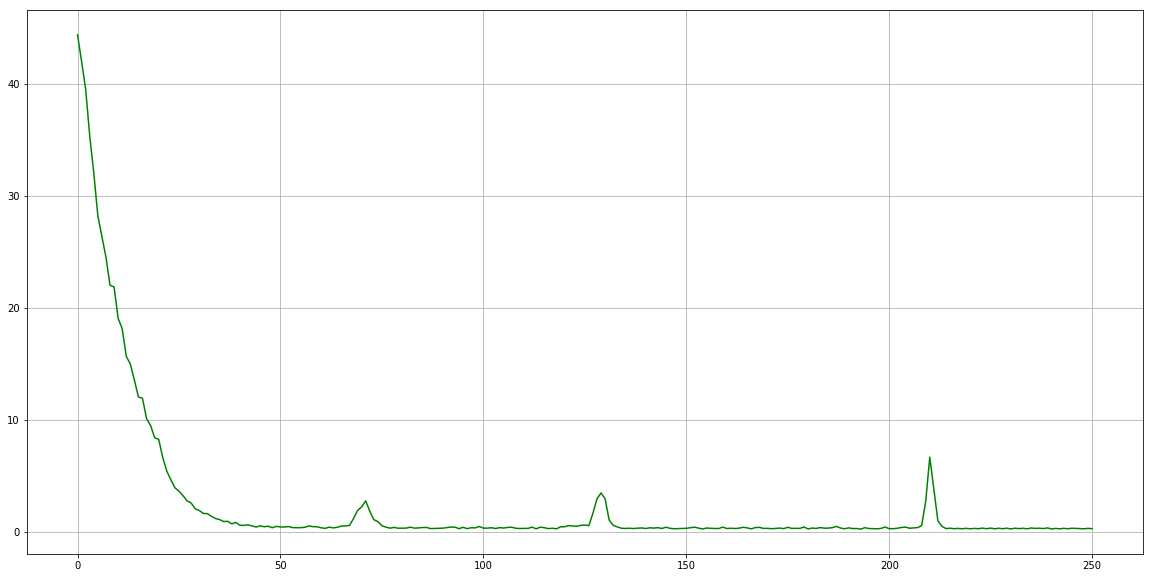

In [44]:
#train_model(features, salient_features, description_matrix, description_seq_len, caption_masks, caption_matrix)
train_model()

In [44]:

def test():
    start_time = time.time()
    model_path = 'models_batch/combined_image_merge-300'

    #tf_feats, tf_caption, tf_description, tf_desc_seq_length, tf_generated_sent, tf_generated_probabilities = generate_perplexity_model()
    model = Hierarchical_VIST()
    tf_feats, tf_salient_feats, tf_caption, tf_description, tf_desc_seq_length, tf_generated_sent, tf_generated_probabilities, tf_phase = model.generate_perplexity_model()
    sess = tf.InteractiveSession()

    saver = tf.train.Saver()
    #saver = tf.train.import_meta_graph('../model_batch_v2/base_model_v2-1500.meta')
    saver.restore(sess, model_path)
    
    test_fd = open('result/HRNN_results_merge.txt', 'w')
    output_sentences = dict()
    part = 0
    for key, value in splitted_train_data.items():
        if part == 50:
            break
        part +=1
        features = []
        salient_features = []
        photo_ids = []
        descriptions = []
        caption_matrix = []
        standalone_caption_matrix = []
        standalone_caption_seq_length = []
        for i in range(n_image):
            description = value[i]['description']
            salient_feat = value[i]['salient_features']
            standalone_description = value[i]['stndalone_description']
            #description = get_randomtext()
            org_features = value[i]['features']
            seq_length = get_sequence_length(standalone_description)
            
            org_features = org_features.flatten()
            salient_feat = salient_feat.flatten()
            
            photo_id = value[i]['photo_id']
            
            _caption_matrix = get_caption_matrix(description, N_max_word)
            _standalone_description_matrix = get_caption_matrix(standalone_description, N_max_desc_word)
            
            #_features = np.concatenate([org_features, _salient_features])
            features.append(org_features)
            salient_features.append(salient_feat)
            caption_matrix.append(_caption_matrix)
            standalone_caption_matrix.append(_standalone_description_matrix)
            standalone_caption_seq_length.append(seq_length)
            
            photo_ids.append(photo_id)
            descriptions.append(description)
            
        features = np.array(features)
        features = np.asarray(np.reshape(features, (1, n_image, -1)))
        
        salient_features = np.array(salient_features)
        salient_features = np.asarray(np.reshape(salient_features, (1, n_image, -1)))
        
        caption_matrix = np.array(caption_matrix)
        caption_matrix = np.asarray(np.reshape(caption_matrix, (1, n_image, -1)))
        
        standalone_caption_matrix = np.array(standalone_caption_matrix)
        standalone_caption_seq_length = np.array(standalone_caption_seq_length)
        standalone_caption_matrix = np.asarray(np.reshape(standalone_caption_matrix, (1, n_image, -1)))
        standalone_caption_seq_length = np.asarray(np.reshape(standalone_caption_seq_length, 
                                                                          (1, n_image, -1)))
        
        test_fd.write("story: " + key + '\n')
        test_fd.write("photo_ids: ")
        for ids in photo_ids:
            test_fd.write(ids + " ")
        test_fd.write("\n")
            
        
        each_paragraph = []
        current_paragraph = ""
        
        
        generated_sentence_indexes, probabilites = sess.run([tf_generated_sent, tf_generated_probabilities], feed_dict={
            tf_feats: features,
            tf_salient_feats:salient_features,
            tf_caption: caption_matrix,
            tf_description: standalone_caption_matrix, 
            tf_desc_seq_length: standalone_caption_seq_length,
            tf_phase:0
        })
            
        #print(generated_sentence_indexes)
        #for paragraph in generated_sentence_indexes:
         #   for sentence_list in paragraph:
          #      for word_indices in sentence_list[0]:
           #         each_sent = []
            #        for word_index in word_indices:
             #           each_sent.append(idx2word[word_index])
              #      each_paragraph.append(each_sent)
        for sentence_list in generated_sentence_indexes:
            each_sent = []
            for word_index in sentence_list:
                each_sent.append(idx2word[word_index])
            each_paragraph.append(each_sent)
            
        current_sent = ''
        for each_sent in each_paragraph:
            for each_word in each_sent:
                current_sent += each_word + ' '
                
            current_sent = current_sent.replace('eos', '')
            current_sent = current_sent.replace('pad', '')
            current_sent = current_sent + '.'
            current_sent = current_sent.replace(' .', '.')
            current_sent = current_sent.replace(' ,', ',')
            current_sent += '\n'
            
            
        test_fd.write(" generated text: " + current_sent + '\n')
        test_fd.write(" original text: " + '\n')
        for description in descriptions:
            test_fd.write(description + '\n')
        test_fd.write("\n")
        per = perplexity(descriptions, probabilites)
        test_fd.write("perplexity: " + str(per) +'\n')
        test_fd.write("\n")
        
        print(current_sent)
        print(descriptions)
        output_sentences[key] = current_sent
        
    test_fd.close()
    print ("Time cost: " + str(time.time()-start_time))
    return output_sentences

In [45]:
#val_features, val_salient_features, val_caption_matrix, val_caption_masks, val_description_matrix, val_description_seq_len = create_dataset(splitted_validation_data, 1, 100)

In [46]:
output = test()

INFO:tensorflow:Restoring parameters from models_batch/combined_image_merge-300
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 5
[0. 0. 0. ... 0. 0. 0.]
word_id 6
[0. 0. 0. ... 0. 0. 0.]
word_id 7
[0. 0. 0. ... 0. 0. 0.]
word_id 8
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 9
[0. 0. 0. ... 0. 0. 0.]
word_id 10
[0. 0. 0. ... 0. 0. 0.]
word_id 11
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 13
[0. 0. 0. ... 0. 0. 0.]
word_id 14
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 16
[0. 0. 0. ... 0. 0. 0.]
word_id 17
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 18
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 19
[0. 0. 0. ... 0. 0. 0.]
word_id 20
[0. 0. 0. ... 0. 0. 0.]
word_id 21
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. .

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 78
[0. 0. 0. ... 0. 0. 0.]
word_id 47
[0. 0. 0. ... 0. 0. 0.]
word_id 128
[0. 0. 0. ... 0. 0. 0.]
word_id 129
[0. 0. 0. ... 0. 0. 0.]
word_id 6
[0. 0. 0. ... 0. 0. 0.]
word_id 130
[0. 0. 0. ... 0. 0. 0.]
word_id 88
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 78
[0. 0. 0. ... 0. 0. 0.]
word_id 108
[0. 0. 0. ... 0. 0. 0.]
word_id 69
[0. 0. 0. ... 0. 0. 0.]
word_id 31
[0. 0. 0. ... 0. 0. 0.]
word_id 131
[0. 0. 0. ... 0. 0. 0.]
word_id 132
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 51
[0. 0. 0. ... 0. 0. 0.]
word_id 9
[0. 0. 0. ... 0. 0. 0.]
word_id 69
[0. 0. 0. ... 0. 0. 0.]
word_id 100
[0. 0. 0. ... 0. 0. 0.]
word_id 133
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 134
[0. 0. 0. ... 0. 0. 0.]
word_id 135
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 116
[0. 0. 0. ... 0. 0. 0.]
word_id 212
[0. 0. 0. ... 0. 0. 0.]
word_id 213
[0. 0. 0. ... 0. 0. 0.]
word_id 214
[0. 0. 0. ... 0. 0. 0.]
word_id 169
[0. 0. 0. ... 0. 0. 0.]
word_id 58
[0. 0. 0. ... 0. 0. 0.]
word_id 169
[0. 0. 0. ... 0. 0. 0.]
word_id 215
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 216
[0. 0. 0. ... 0. 0. 0.]
word_id 217
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 51
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 57
[0. 0. 0. ... 0. 0. 0.]
word_id 218
[0. 0. 0. ... 0. 0. 0.]
word_id 149
[0. 0. 0. ... 0. 0. 0.]
word_id 3
[0. 0. 0. ... 0. 0. 0.]
word_id 219
[0. 0. 0. ... 0. 0. 0.]
word_id 169
[0. 0. 0. ... 0. 0. 0.]
word_id 58
[0. 0. 0. ... 0. 0. 0.]
word_id 169
[0. 0. 0. ... 0. 0. 0.]
word_id 9
[0. 0. 0. ... 0. 0. 0.]
word_id 220
[0. 0. 0. ... 0. 0. 0.]
word_id 170
[0. 0. 0. ... 0. 0. 0.]
word_id 1

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 116
[0. 0. 0. ... 0. 0. 0.]
word_id 287
[0. 0. 0. ... 0. 0. 0.]
word_id 288
[0. 0. 0. ... 0. 0. 0.]
word_id 58
[0. 0. 0. ... 0. 0. 0.]
word_id 78
[0. 0. 0. ... 0. 0. 0.]
word_id 256
[0. 0. 0. ... 0. 0. 0.]
word_id 270
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 289
[0. 0. 0. ... 0. 0. 0.]
word_id 11
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 66
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 46
[0. 0. 0. ... 0. 0. 0.]
word_id 68
[0. 0. 0. ... 0. 0. 0.]
word_id 99
[0. 0. 0. ... 0. 0. 0.]
word_id 271
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 3
[0. 0. 0. ... 0. 0. 0.]
word_id 290
[0. 0. 0. ... 0. 0. 0.]
word_id 291
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 292
[0. 0. 0. ... 0. 0. 0.]
word_id 248
[0. 0. 0. ... 0. 0. 0.]
word_id 11
[0. 0. 0. ... 0. 0. 0.]
word_id 86
[0.

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 147
[0. 0. 0. ... 0. 0. 0.]
word_id 349
[0. 0. 0. ... 0. 0. 0.]
word_id 84
[0. 0. 0. ... 0. 0. 0.]
word_id 350
[0. 0. 0. ... 0. 0. 0.]
word_id 88
[0. 0. 0. ... 0. 0. 0.]
word_id 96
[0. 0. 0. ... 0. 0. 0.]
word_id 351
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 84
[0. 0. 0. ... 0. 0. 0.]
word_id 350
[0. 0. 0. ... 0. 0. 0.]
word_id 88
[0. 0. 0. ... 0. 0. 0.]
word_id 96
[0. 0. 0. ... 0. 0. 0.]
word_id 18
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 226
[0. 0. 0. ... 0. 0. 0.]
word_id 352
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 353
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 354
[0. 0. 0. ... 0. 0. 0.]
word_id 355
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 356
[0. 0. 0. ... 0. 0. 0.]
word_id 11
[0. 

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 84
[0. 0. 0. ... 0. 0. 0.]
word_id 14
[0. 0. 0. ... 0. 0. 0.]
word_id 349
[0. 0. 0. ... 0. 0. 0.]
word_id 3
[0. 0. 0. ... 0. 0. 0.]
word_id 219
[0. 0. 0. ... 0. 0. 0.]
word_id 25
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 400
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 409
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 311
[0. 0. 0. ... 0. 0. 0.]
word_id 410
[0. 0. 0. ... 0. 0. 0.]
word_id 203
[0. 0. 0. ... 0. 0. 0.]
word_id 411
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 201
[0. 0. 0. ... 0. 0. 0.]
word_id 201
[0. 0. 0. ... 0. 0. 0.]
word_id 201
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 412
[0. 0. 0. ... 0. 0. 0.]
word_id 413
[0. 0. 0. ... 0. 0. 0.]
word_id 128
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 406


word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 69
[0. 0. 0. ... 0. 0. 0.]
word_id 43
[0. 0. 0. ... 0. 0. 0.]
word_id 456
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 457
[0. 0. 0. ... 0. 0. 0.]
word_id 246
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 458
[0. 0. 0. ... 0. 0. 0.]
word_id 459
[0. 0. 0. ... 0. 0. 0.]
word_id 317
[0. 0. 0. ... 0. 0. 0.]
word_id 460
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 175
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 422
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 125
[0. 0. 0. ... 0. 0. 0.]
word_id 211
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 84
[0. 0. 0. ... 0. 0. 0.]
word_id 275
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 214
[0. 0. 0. ... 0. 0. 0.]
word_id 461
[0. 0. 0. ... 0. 0. 0.]
word_id 3
[0. 0. 0. ... 0. 0. 0.]
word_id 246
[0. 0. 0. ... 0. 0. 0.]
word_id 3

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 509
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 222
[0. 0. 0. ... 0. 0. 0.]
word_id 330
[0. 0. 0. ... 0. 0. 0.]
word_id 220
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 162
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 359
[0. 0. 0. ... 0. 0. 0.]
word_id 391
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 163
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 160
[0. 0. 0. ... 0. 0. 0.]
word_id 489
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 47
[0. 0. 0. ... 0. 0. 0.]
word_id 128
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 510
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 511
[0. 0. 0. ... 0. 0. 0.]
word_id 512
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 317
[

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 78
[0. 0. 0. ... 0. 0. 0.]
word_id 256
[0. 0. 0. ... 0. 0. 0.]
word_id 69
[0. 0. 0. ... 0. 0. 0.]
word_id 270
[0. 0. 0. ... 0. 0. 0.]
word_id 76
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 400
[0. 0. 0. ... 0. 0. 0.]
word_id 78
[0. 0. 0. ... 0. 0. 0.]
word_id 47
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 87
[0. 0. 0. ... 0. 0. 0.]
word_id 540
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 6
[0. 0. 0. ... 0. 0. 0.]
word_id 313
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 220
[0. 0. 0. ... 0. 0. 0.]
word_id 307
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 58
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 381
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 552
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 509
[0. 0

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 589
[0. 0. 0. ... 0. 0. 0.]
word_id 219
[0. 0. 0. ... 0. 0. 0.]
word_id 203
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 204
[0. 0. 0. ... 0. 0. 0.]
word_id 25
[0. 0. 0. ... 0. 0. 0.]
word_id 212
[0. 0. 0. ... 0. 0. 0.]
word_id 401
[0. 0. 0. ... 0. 0. 0.]
word_id 276
[0. 0. 0. ... 0. 0. 0.]
word_id 374
[0. 0. 0. ... 0. 0. 0.]
word_id 526
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 590
[0. 0. 0. ... 0. 0. 0.]
word_id 317
[0. 0. 0. ... 0. 0. 0.]
word_id 591
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 592
[0. 0. 0. ... 0. 0. 0.]
word_id 8
[0. 0. 0. ... 0. 0. 0.]
word_id 186
[0. 0. 0. ... 0. 0. 0.]
word_id 215
[0. 0. 0. ... 0. 0. 0.]
word_id 58
[0. 0. 0. ... 0. 0. 0.]
word_id 116
[0. 0. 0. ... 0. 0. 0.]
word_id 

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 401
[0. 0. 0. ... 0. 0. 0.]
word_id 9
[0. 0. 0. ... 0. 0. 0.]
word_id 118
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 641
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 173
[0. 0. 0. ... 0. 0. 0.]
word_id 400
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 404
[0. 0. 0. ... 0. 0. 0.]
word_id 208
[0. 0. 0. ... 0. 0. 0.]
word_id 642
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 643
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 46
[0. 0. 0. ... 0. 0. 0.]
word_id 9
[0. 0. 0. ... 0. 0. 0.]
word_id 220
[0. 0. 0. ... 0. 0. 0.]
word_id 396
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 93
[0. 0. 0. ... 0. 0. 0.]
word_id 118
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 680
[0. 0. 0. ... 0. 0. 0.]
word_id 79
[0. 0. 0. ... 0. 0. 0.]
word_id 4
[0. 0. 0. ... 0. 0. 0.]
word_id 108
[0. 0. 0. ... 0. 0. 0.]
word_id 6
[0. 0. 0. ... 0. 0. 0.]
word_id 681
[0. 0. 0. ... 0. 0. 0.]
word_id 50
[0. 0. 0. ... 0. 0. 0.]
word_id 275
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 175
[0. 0. 0. ... 0. 0. 0.]
word_id 25
[0. 0. 0. ... 0. 0. 0.]
word_id 103
[0. 0. 0. ... 0. 0. 0.]
word_id 682
[0. 0. 0. ... 0. 0. 0.]
word_id 58
[0. 0. 0. ... 0. 0. 0.]
word_id 683
[0. 0. 0. ... 0. 0. 0.]
word_id 684
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 466
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 685
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 185
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 46
[0. 

word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 217
[0. 0. 0. ... 0. 0. 0.]
word_id 51
[0. 0. 0. ... 0. 0. 0.]
word_id 30
[0. 0. 0. ... 0. 0. 0.]
word_id 12
[0. 0. 0. ... 0. 0. 0.]
word_id 400
[0. 0. 0. ... 0. 0. 0.]
word_id 717
[0. 0. 0. ... 0. 0. 0.]
word_id 17
[0. 0. 0. ... 0. 0. 0.]
word_id 128
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 718
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 719
[0. 0. 0. ... 0. 0. 0.]
word_id 74
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0. ... 0. 0. 0.]
word_id 720
[0. 0. 0. ... 0. 0. 0.]
word_id 9
[0. 0. 0. ... 0. 0. 0.]
word_id 23
[0. 0. 0. ... 0. 0. 0.]
word_id 3
[0. 0. 0. ... 0. 0. 0.]
word_id 1
[0. 0. 0. ... 0. 0. 0.]
word_id 0
[0. 0. 0. ... 0. 0. 0.]
word_id 15
[0. 0. 0. ... 0. 0. 0.]
word_id 18
[0. 0. 0. ... 0. 0. 0.]
word_id 182
[0. 0. 0. ... 0. 0. 0.]
word_id 48
[0. 0. 0. ... 0. 0. 0.]
word_id 39
[0. 0. 0. ... 0. 0. 0.]
word_id 22
[0. 0. 0

In [ ]:
def photo_captions(photo_id):
    for key, values in train_story.items():
        for value in values:
            if value['photo_id'] == photo_id:
                print(value['description'])
    

In [ ]:

def test(features, salient_features, standalone_caption_matrix, caption_matrix, standalone_caption_seq_length):
    start_time = time.time()
    model_path = 'models_batch/model_adam_merge-500'

    #tf_feats, tf_caption, tf_description, tf_desc_seq_length, tf_generated_sent, tf_generated_probabilities = generate_perplexity_model()
    model = Hierarchical_VIST()
    tf_feats, tf_salient_feats, tf_caption, tf_description, tf_desc_seq_length, tf_generated_sent, tf_generated_probabilities, tf_phase = model.generate_perplexity_model()
    sess = tf.InteractiveSession()

    saver = tf.train.Saver()
    #saver = tf.train.import_meta_graph('../model_batch_v2/base_model_v2-1500.meta')
    saver.restore(sess, model_path)
    
    test_fd = open('result/HRNN_results_merge.txt', 'w')
    output_sentences = dict()
    data_length = features.shape[0]
    for i in range(data_length):
        if part == 50:
            break
        part +=1
        features = []
        salient_features = []
        photo_ids = []
        descriptions = []
        caption_matrix = []
        standalone_caption_matrix = []
        standalone_caption_seq_length = []
        for i in range(n_image):
            description = value[i]['description']
            standalone_description = value[i]['stndalone_description']
            #description = get_randomtext()
            org_features = value[i]['features']
            seq_length = get_sequence_length(standalone_description)
            
            org_features = org_features.flatten()
            
            photo_id = value[i]['photo_id']
            
            _caption_matrix = get_caption_matrix(description)
            _standalone_description_matrix = get_caption_matrix(standalone_description)
            
            #_features = np.concatenate([org_features, _salient_features])
            features.append(org_features)
            caption_matrix.append(_caption_matrix)
            standalone_caption_matrix.append(_standalone_description_matrix)
            standalone_caption_seq_length.append(seq_length)
            
            photo_ids.append(photo_id)
            descriptions.append(description)
            
        features = np.array(features)
        features = np.asarray(np.reshape(features, (1, n_image, -1)))
        caption_matrix = np.array(caption_matrix)
        caption_matrix = np.asarray(np.reshape(caption_matrix, (1, n_image, -1)))
        
        standalone_caption_matrix = np.array(standalone_caption_matrix)
        standalone_caption_seq_length = np.array(standalone_caption_seq_length)
        standalone_caption_matrix = np.asarray(np.reshape(standalone_caption_matrix, (1, n_image, -1)))
        standalone_caption_seq_length = np.asarray(np.reshape(standalone_caption_seq_length, 
                                                                          (1, n_image, -1)))
        
        test_fd.write("story: " + key + '\n')
        test_fd.write("photo_ids: ")
        for ids in photo_ids:
            test_fd.write(ids + " ")
        test_fd.write("\n")
            
        
        each_paragraph = []
        current_paragraph = ""
        
        
        generated_sentence_indexes, probabilites = sess.run([tf_generated_sent, tf_generated_probabilities], feed_dict={
            tf_feats: features,
            tf_caption: caption_matrix,
            tf_description: standalone_caption_matrix, 
            tf_desc_seq_length: standalone_caption_seq_length
        })
            
        #print(generated_sentence_indexes)
        #for paragraph in generated_sentence_indexes:
         #   for sentence_list in paragraph:
          #      for word_indices in sentence_list[0]:
           #         each_sent = []
            #        for word_index in word_indices:
             #           each_sent.append(idx2word[word_index])
              #      each_paragraph.append(each_sent)
        for sentence_list in generated_sentence_indexes:
            each_sent = []
            for word_index in sentence_list:
                each_sent.append(idx2word[word_index])
            each_paragraph.append(each_sent)
            
        current_sent = ''
        for each_sent in each_paragraph:
            for each_word in each_sent:
                current_sent += each_word + ' '
                
            current_sent = current_sent.replace('eos', '')
            current_sent = current_sent.replace('pad', '')
            current_sent = current_sent + '.'
            current_sent = current_sent.replace(' .', '.')
            current_sent = current_sent.replace(' ,', ',')
            current_sent += '\n'
            
            
        test_fd.write(" generated text: " + current_sent + '\n')
        test_fd.write(" original text: " + '\n')
        for description in descriptions:
            test_fd.write(description + '\n')
        test_fd.write("\n")
        per = perplexity(descriptions, probabilites)
        test_fd.write("perplexity: " + str(per) +'\n')
        test_fd.write("\n")
        
        print(current_sent)
        print(descriptions)
        output_sentences[key] = current_sent
        
    test_fd.close()
    print ("Time cost: " + str(time.time()-start_time))
    return output_sentences